<a href="https://colab.research.google.com/github/arishp/AutomobileFingerPrinting/blob/main/SiameseCarReID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import random
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
import zipfile

In [2]:
local_zip = '/content/drive/MyDrive/colab_ds/VeRi.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Veri')
zip_ref.close()

In [4]:
class data():
  def __init__(self, train_path , test_path):
    self.train_path = train_path
    self.test_path = test_path
  
  def load_data(self):
    train_df = pd.read_excel(self.train_path)
    test_df = pd.read_excel(self.test_path)
    train_df.columns = ['ImageName' , 'VehicleID' ,'CameraID' , 'ColorID' ,'TypeID']
    test_df.columns = ['ImageName' , 'VehicleID' ,'CameraID' , 'ColorID' ,'TypeID']
    return train_df, test_df

  def Enumerate(self, col):
    dict_train = {}
    dict_test  = {}
    self.train_df, self.test_df = self.load_data()
    arr_train = np.sort(self.train_df[col].unique())
    arr_test = np.sort(self.test_df[col].unique())
    for count, item in enumerate(arr_train):
      dict_train[item] = count
    for count, item in enumerate(arr_test):
      dict_test[item] = count
    return dict_train ,dict_test

  def change(self):
    VehicleID_dict_train, VehicleID_dict_test = self.Enumerate('VehicleID')
    ColorID_dict_train, ColorID_dict_test = self.Enumerate('ColorID')
    TypeID_dict_train, TypeID_dict_test = self.Enumerate('TypeID')
    self.train_df = self.train_df.replace({"VehicleID": VehicleID_dict_train})
    self.train_df = self.train_df.replace({"ColorID": ColorID_dict_train})
    self.train_df = self.train_df.replace({"TypeID": TypeID_dict_train})
    self.test_df = self.test_df.replace({"VehicleID": VehicleID_dict_test})
    self.test_df = self.test_df.replace({"ColorID": ColorID_dict_test})
    self.test_df = self.test_df.replace({"TypeID": TypeID_dict_test})
    return self.train_df, self.test_df
      
train_path = 'train_label.xlsx'
test_path = 'test_label.xlsx'

m = data(train_path, test_path)
train_df , test_df = m.change()

print(train_df.head(2))
print(test_df.head(2))

                  ImageName  VehicleID CameraID  ColorID  TypeID
0  0001_c001_00016450_0.jpg          0     c001        0       3
1  0001_c001_00016460_0.jpg          0     c001        0       3
                  ImageName  VehicleID CameraID  ColorID  TypeID
0  0002_c002_00030600_0.jpg          0     c002        0       3
1  0002_c002_00030605_1.jpg          0     c002        0       3


In [5]:
grpdf = train_df.groupby(['CameraID','VehicleID']).count()
table = pd.pivot_table(grpdf, values='ImageName', index=['VehicleID'], columns=['CameraID'], aggfunc=np.sum)
train_df['CameraID'] =  train_df['CameraID'].astype(str).str[-2:].astype(np.int64)
table = table.reset_index()
print(table.columns)

Index(['VehicleID', 'c001', 'c002', 'c003', 'c004', 'c005', 'c006', 'c007',
       'c008', 'c009', 'c010', 'c011', 'c012', 'c013', 'c014', 'c015', 'c016',
       'c017', 'c018', 'c019', 'c020'],
      dtype='object', name='CameraID')


In [6]:
def create_neg_pairs():
    pairs = []
    uniVID = train_df['VehicleID'].value_counts().index.sort_values() #gets unique values of VehicleID
    for VID in uniVID:
        x = np.squeeze(table[table['VehicleID'] ==VID].values)[1:]  #to query 'table' row by row using VID
        idx = pd.Index(x).notnull() 
        image_ID_list = []
        for i in range(len(idx)):
            if idx[i] == True:
                image_ID_list.append(i+1)
                i+1
            else:
                i+1     



def create_positive_pairs():
  pairlist=[]  #final pairlist
  uniVID = train_df['VehicleID'].value_counts().index.sort_values() #gets unique values of VehicleID
  for VID in uniVID:
    x = np.squeeze(table[table['VehicleID'] ==VID].values)[1:]  #to query 'table' row by row using VID
    idx = pd.Index(x).notnull() 
    image_ID_list = []
    for i in range(len(idx)):
      if idx[i] == True:
        image_ID_list.append(i+1)
        i+1
      else:
        i+1
    tdf = []
    for ele in image_ID_list:
      tdf.append(train_df['ImageName'][(train_df['CameraID']==ele) & (train_df['VehicleID'] == VID)].values)
    pairs = []
    for i in range(0,2):
      ind1 = random.randint(0, len(tdf[0+i])-1)
      x1 = tdf[0+i][ind1]
      pairs.append(x1)
    pairlist.append(pairs)
      #print("PSTVE PAIR VEHICLE ID {} = {} ".format(VID,pairs))
  return pairlist

pairlist1  = create_positive_pairs()
pairlist2  = create_positive_pairs()
pairlist3  = create_positive_pairs()
pairlist4  = create_positive_pairs()
pairlist5  = create_positive_pairs()

ar_p1 = np.array(pairlist1)
ar_p2 = np.array(pairlist2)
ar_p3 = np.array(pairlist3)
ar_p4 = np.array(pairlist4)
ar_p5 = np.array(pairlist5)

ar_pairlists = np.vstack((ar_p1,ar_p2,ar_p3,ar_p4,ar_p5))

positive_pair_df = pd.DataFrame(data = ar_pairlists,columns =['Image1','Image2'])
positive_pair_df['label'] = 1
positive_pair_df.drop_duplicates(inplace=True)

print(positive_pair_df.shape)
print(positive_pair_df.head())

(2724, 3)
                     Image1                    Image2  label
0  0001_c001_00016500_0.jpg  0001_c002_00016885_0.jpg      1
1  0003_c001_00021515_0.jpg  0003_c012_00020480_0.jpg      1
2  0004_c001_00044020_0.jpg  0004_c012_00044415_1.jpg      1
3  0007_c014_00049790_0.jpg  0007_c015_00049590_0.jpg      1
4  0008_c014_00078640_0.jpg  0008_c015_00078720_0.jpg      1


In [7]:
def create_neg_pairs():
    pairs = []
    uniVID = train_df['VehicleID'].value_counts().index.sort_values() #gets unique values of VehicleID
    for VID in uniVID:
        x = np.squeeze(table[table['VehicleID'] ==VID].values)[1:]  #to query 'table' row by row using VID
        idx = pd.Index(x).notnull() 
        image_ID_list = []
        for i in range(len(idx)):
            if idx[i] == True:
                image_ID_list.append(i+1)
                i+1
            else:
                i+1     
        #print("\n___________________________________________________________________________________________________")
        #print("For Vehicle ID {}, the active cameras are {}, total = {} ".format(VID,image_ID_list, len(image_ID_list)))
        
        tdf = []
        i = 0 
        for ele in image_ID_list:
             
            tdf.append(train_df['ImageName'][(train_df['CameraID']==ele) & (train_df['VehicleID'] == VID)].values)  
            #print("\n\n\n Images from Camera {} are {}".format(ele,tdf[i]))
            i=i+1

        ind1 = random.randint(0,len(image_ID_list)-1)
        #print("SELECTED CAMERA ANGLE FOR VID {} IS {}".format(VID,ind1))
        ind2 = random.randint(0, len(tdf[ind1])-1)
        x1 = tdf[ind1][ind2]
        #print("SELECTED RANDOM IMAGE x1 FROM THIS ANGLE IS {}".format(str(tdf[ind1][ind2])))
        randomVID = [el for el in uniVID if el != VID]
        random_vid = random.choice(randomVID)
        rdf = train_df['ImageName'][train_df['VehicleID'] == random_vid]
        x2 = random.choice(rdf.to_list())
        pairs.append([x1,x2])
        #print(x1,x2)

    return pairs
    

pairlist1  = create_neg_pairs()
pairlist2  = create_neg_pairs()
pairlist3  = create_neg_pairs()
pairlist4 = create_neg_pairs()
pairlist5 = create_neg_pairs()

ar_p1 = np.array(pairlist1)
ar_p2 = np.array(pairlist2)
ar_p3 = np.array(pairlist3)
ar_p4 = np.array(pairlist4)
ar_p5 = np.array(pairlist5)

ar_pairlists = np.vstack((ar_p1,ar_p2,ar_p3,ar_p4,ar_p5))
negative_pair_df = pd.DataFrame(data = ar_pairlists,columns =['Image1','Image2'])
negative_pair_df['label'] = 0
negative_pair_df.drop_duplicates(inplace=True)

print(negative_pair_df.shape)
print(negative_pair_df.head(10))

(2875, 3)
                     Image1                    Image2  label
0  0001_c015_00013225_0.jpg  0204_c015_00045270_0.jpg      0
1  0003_c019_00019495_0.jpg  0442_c011_00007685_0.jpg      0
2  0004_c012_00044435_0.jpg  0549_c002_00048010_0.jpg      0
3  0007_c015_00049570_0.jpg  0115_c016_00031410_0.jpg      0
4  0008_c019_00079560_0.jpg  0015_c014_00069445_0.jpg      0
5  0010_c012_00033390_0.jpg  0470_c008_00002230_0.jpg      0
6  0011_c014_00087430_1.jpg  0008_c014_00078660_0.jpg      0
7  0012_c015_00050555_1.jpg  0021_c003_00013475_0.jpg      0
8  0013_c015_00068720_0.jpg  0137_c006_00008115_1.jpg      0
9  0015_c013_00000480_0.jpg  0022_c006_00066630_0.jpg      0


In [8]:
siamese_df = positive_pair_df.copy()
siamese_df = siamese_df.append(negative_pair_df,ignore_index=True)
siamese_df = siamese_df.sample(frac=1).reset_index(drop=True)
siamese_df['label'] = siamese_df['label'].astype(str)
siamese_df.head(10)

,Image1,Image2,label
0,0372_c015_00066415_0.jpg,0161_c003_00023640_0.jpg,0
1,0433_c014_00051205_0.jpg,0433_c015_00050940_0.jpg,1
2,0147_c011_00055420_0.jpg,0552_c006_00037875_0.jpg,0
3,0395_c001_00050390_0.jpg,0395_c002_00051030_0.jpg,1
4,0272_c001_00040555_0.jpg,0272_c002_00038990_0.jpg,1
5,0760_c012_00057715_0.jpg,0640_c009_00015265_0.jpg,0
6,0550_c001_00061715_0.jpg,0550_c002_00062490_0.jpg,1
7,0556_c001_00038670_0.jpg,0556_c002_00044905_0.jpg,1
8,0616_c012_00085930_0.jpg,0168_c013_00083900_0.jpg,0
9,0481_c003_00027560_3.jpg,0481_c004_00027455_0.jpg,1


In [9]:
def initialize_base_network():
    VGGpart = tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(224,224,3,))

    for layer in VGGpart.layers:
        layer.trainable = True
    
    last_layer = VGGpart.get_layer('block5_pool')
    print('last layer output shape ', last_layer.output_shape)
    last_output = last_layer.output                

    x = Flatten(name="flatten_input")(last_output)
    x = Dense(512, activation='relu', name="first_base_dense")(x)
    #x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(256, activation='relu', name="second_base_dense")(x)
    #x = Dropout(0.1, name="second_dropout")(x)
    output = Dense(128, activation='relu', name="third_base_dense")(x)
    model1 = tf.keras.models.Model(inputs=VGGpart.input, outputs=output)

    return model1


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

base_network = initialize_base_network()
# create the left input and point to the base network
input_a = Input(shape=(224,224,3,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(224,224,3,), name="right_input")
vect_output_b = base_network(input_b)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([vect_output_a,vect_output_b])
    
# Add a dense layer with a sigmoid unit to generate the similarity score
output = tf.keras.layers.Dense(1,activation='sigmoid')(L1_distance)
# measure the similarity of the two vector outputs
#output = Lambda(euclidean_distance, name="output_layer",output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
last layer output shape  (None, 7, 7, 512)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          27724480    left_input[0][0]                 
                                                                 right_input[0][0]                
___________________________________________________________________________________

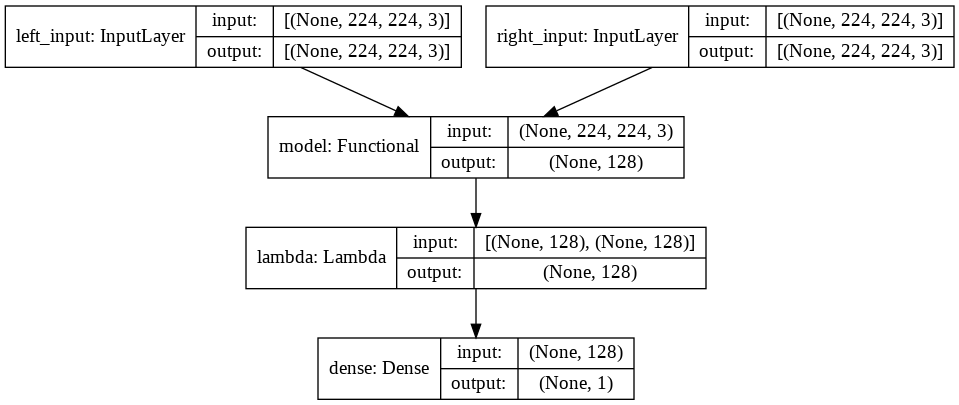

In [10]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [11]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [12]:
train_siamese = siamese_df[0: int(len(siamese_df) * 0.80)]
val_siamese = siamese_df[int(len(siamese_df) * 0.80) : ]

In [13]:
generator = ImageDataGenerator(rescale = 1/255.0)


def get_flow_from_dataframe(generator, dataframe,directory="/tmp/Veri/VeRi/image_train",
                            image_shape=(224, 224),
                            color_mode='rgb', batch_size=16):

    train_generator_1 = generator.flow_from_dataframe(dataframe, directory = directory,
                                                        target_size=image_shape,
                                                        color_mode=color_mode,
                                                        x_col='Image1',
                                                        y_col='label',
                                                        shuffle = False,
                                                        class_mode='binary',                                                
                                                        batch_size=batch_size,                                                        
                                                        drop_duplicates=False)

    train_generator_2 = generator.flow_from_dataframe(dataframe, directory = directory,     
                                                        target_size=image_shape,
                                                        color_mode=color_mode,
                                                        x_col='Image2',
                                                        y_col='label',
                                                        shuffle = False,
                                                        class_mode='binary',                                          
                                                        batch_size=batch_size,                                                      
                                                        drop_duplicates=False)
    while True:
        x_1 = train_generator_1.next()
        x_2 = train_generator_2.next()
        yield [ x_1[0] , x_2[0]  ] , x_1[1]

In [14]:
train_gen = get_flow_from_dataframe(generator, train_siamese, image_shape=(224,224),
                                        color_mode='rgb',
                                        batch_size=16)

val_gen = get_flow_from_dataframe(generator, val_siamese, image_shape=(224,224),
                                        color_mode='rgb',
                                        batch_size=16)

In [15]:
train_siamese.head(3)

,Image1,Image2,label
0,0372_c015_00066415_0.jpg,0161_c003_00023640_0.jpg,0
1,0433_c014_00051205_0.jpg,0433_c015_00050940_0.jpg,1
2,0147_c011_00055420_0.jpg,0552_c006_00037875_0.jpg,0


Found 4479 validated image filenames belonging to 2 classes.
Found 4479 validated image filenames belonging to 2 classes.
LABEL : 0.0


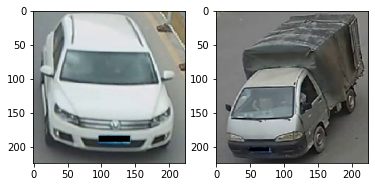

In [16]:
a = next(train_gen)[0:]
a1 = a[0][0][0]
a2 = a[0][1][0]
c = a[1][0]
rows, cols = 1, 2
plt.subplot(rows, cols, 1)
plt.imshow(a1)
plt.subplot(rows, cols, 2)
plt.imshow(a2)
print("LABEL :", c)

In [17]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
mc =tf.keras.callbacks.ModelCheckpoint('BaselineSiamese1.h5', save_best_only=True)

class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.99):
                print("\nReached 99.0% accuracy so cancelling training!")
                self.model.stop_training = True
mycallback = CustomCallBack()


adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics =['accuracy'])
history = model.fit(train_gen,  steps_per_epoch = len( train_siamese)//16, epochs=20 
                    ,validation_data= val_gen, validation_steps= len(val_siamese)//16
                    ,callbacks= [early_stopping_cb,mc,mycallback])

Epoch 1/20
279/279 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6558Found 1120 validated image filenames belonging to 2 classes.
Found 1120 validated image filenames belonging to 2 classes.
279/279 [==============================] - 173s 475ms/step - loss: 0.6028 - accuracy: 0.6558 - val_loss: 0.5633 - val_accuracy: 0.7018
Epoch 2/20
279/279 [==============================] - 127s 454ms/step - loss: 0.4690 - accuracy: 0.7637 - val_loss: 0.4291 - val_accuracy: 0.7884
Epoch 3/20
279/279 [==============================] - 127s 454ms/step - loss: 0.3836 - accuracy: 0.8205 - val_loss: 0.3628 - val_accuracy: 0.8438
Epoch 4/20
279/279 [==============================] - 126s 453ms/step - loss: 0.3346 - accuracy: 0.8483 - val_loss: 0.3204 - val_accuracy: 0.8634
Epoch 5/20
279/279 [==============================] - 126s 453ms/step - loss: 0.2939 - accuracy: 0.8756 - val_loss: 0.3619 - val_accuracy: 0.8366
Epoch 6/20
279/279 [==============================] - 126s 453ms

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


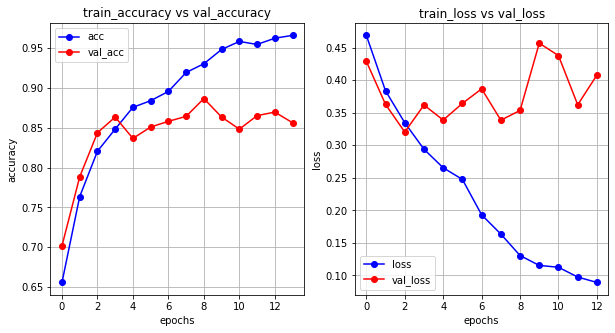

In [27]:
fig = plt.figure(figsize=(10,5))

# Plot accuracy
plt.subplot(121)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(122)
plt.plot(history.history['loss'][1:],'bo-', label = "loss")
plt.plot(history.history['val_loss'][1:], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


#plt.subplot(223)
#plt.plot(history.epoch,history.history['lr'],'o-')
#plt.title("train_loss vs val_loss")
#plt.ylabel("learning rate")
#plt.xlabel("epochs")
#plt.grid(True)
#plt.legend()

print(history.history.keys())